In [48]:
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import math
from statistics import mean
from neurodynex3.leaky_integrate_and_fire import LIF 
from neurodynex3.tools import input_factory, plot_tools
from scipy.signal import find_peaks 
from scipy.stats import mode


In [3]:
# Print Default Values.

print("resting potential: {}".format(LIF.V_REST))
print("membrane resistance: {}".format(LIF.MEMBRANE_RESISTANCE))
print("Firing threshold: {}".format(LIF.FIRING_THRESHOLD))



resting potential: -0.07
membrane resistance: 10000000.0
Firing threshold: -0.05


The equation for the trajectory of membrane potential is found by integrating the equation for a passive membrane. It is known as:
   $u(t) = u_{rest} + RI_{0}exp(-(t-t_{0})/tau) $
    
   $ where  t -> inf $
   $  u(t) -> u_{rest} + RI_{0} $ //The trajectory approaches the resting state.


In [4]:
# 1.1 Minimal Current. Compute minimal aplitude (I_min) of a step current to elicitate a spike.Amplitude is voltage/resistance.

I_min = (LIF.FIRING_THRESHOLD-LIF.V_REST)/LIF.MEMBRANE_RESISTANCE

print('The minimal current for firing is: {}'.format(I_min))

The minimal current for firing is: 2.0000000000000005e-09


WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Number of spikes: 10


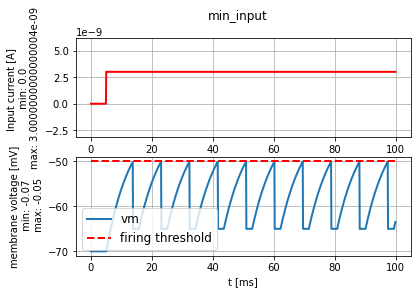

In [5]:
# create a step current with ampltiude 

step_current = input_factory.get_step_current(
               t_start=5, t_end=100, unit_time=b2.ms,
               amplitude = I_min + (0.001 * b2.uamp)
               )

# run the LIF model
# Unspecified paramters will be set to default parameters
(state_monitor, spike_monitor) = LIF.simulate_LIF_neuron(
                                 input_current=step_current,
                                 simulation_time=100 * b2.ms
                                 )

# plot current I and neuron potential vm 
plot_tools.plot_voltage_and_current_traces(
state_monitor, step_current, title="min_input",
firing_threshold=LIF.FIRING_THRESHOLD)

print("Number of spikes: {}".format(spike_monitor.count[0])) # should be 0

For a constant input current I and LIF neuron fires with regular firing frequency f.
A Neurons firing-rate versus input amplitude relationship is an "f-I curve".
Refractory period: amount of time it takes for an excitable membrane to be ready 
#to respond to a second stimulus once it returns to a resting state
Let our refractory period be 3ms.

* The maximum frequency of a neuronal firing is limited by the "absolute refractory period". During this period the sodium ion channels are either open or inactive, and no new action potentials can start. This also means at some point increasing the current will not increase the action potential as the time for the absolute refractory period will remain constant.
* The maximum rate when given a refractory period of 3ms is:
         $ 1/3ms = 333.33Hz. $
Simulation Exercise:
    Inject currents of different amplitudes (from 0nA to 100nA) into a LIF neuron. For each current, run the simulation for 500ms and determine the firing frequency in Hz. Then plot the f-I curve. Pay attention to the low input current.

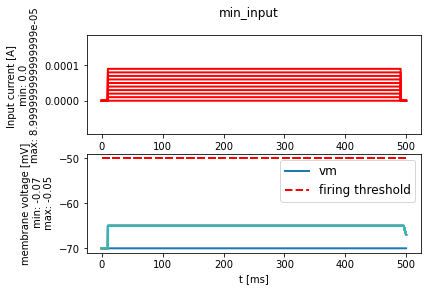

In [6]:
amp_list = np.arange(0,100,10)
firing_rates = list()
refractory_period=6 * b2.ms

for current in amp_list:
    step_current = input_factory.get_step_current(
               t_start=10, t_end=490, unit_time=b2.ms,
               amplitude = current * b2.uamp
               )
    (state_monitor, spike_monitor) = LIF.simulate_LIF_neuron(
                                 input_current=step_current,
                                 simulation_time=500 * b2.ms,
        abs_refractory_period=refractory_period
     )
    # plot current I and neuron potential vm 
    plot_tools.plot_voltage_and_current_traces(
    state_monitor, step_current, title="min_input",
    firing_threshold=LIF.FIRING_THRESHOLD)

    spike_num=spike_monitor.count[0]
    firing_rate = spike_num/(480 * 10**-3)
    firing_rates.append(firing_rate)

We see that the firing rate reaches a constant level.

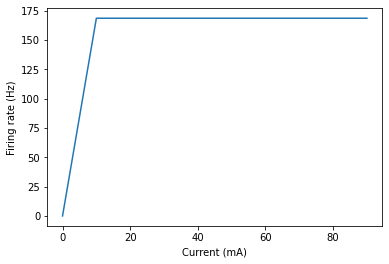

In [47]:
plt.figure()
plt.plot(amp_list, firing_rates)
plt.xlabel('Current (mA)')
plt.ylabel('Firing rate (Hz)')
plt.show()

A LIF neuron is determined by the following parameters: Resting potential, reset voltage, firing threshold, membrane resistance, membrane time-scale, absolute refractory period. By injecting a known test current into a LIF neuron (with unknown parameters), you can determine the neuron properties from the voltage response.

(<AxesSubplot:ylabel='Input current [A] \n min: 0.0 \nmax: 1e-09'>,
 <AxesSubplot:xlabel='t [ms]', ylabel='membrane voltage [mV]\n min: -0.06\n max: -0.052630507382522285'>)

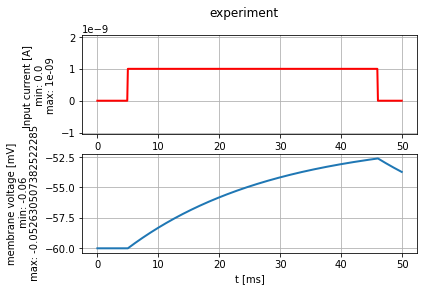

In [13]:
# get a random parameter. provide a random seed to have a reproducible experiment
random_parameters = LIF.get_random_param_set(random_seed=432)


# define your test current
test_current = input_factory.get_step_current(
    t_start=5, t_end=45, unit_time=b2.ms, amplitude= 1 * b2.namp)

# probe the neuron. pass the test current AND the random params to the function
state_monitor, spike_monitor = LIF.simulate_random_neuron(test_current, random_parameters)

# plot
plot_tools.plot_voltage_and_current_traces(state_monitor, test_current, title="experiment")

In [86]:
print('Resting potential:', min(state_monitor.v[0]))
state_monitor.t
indexOfInterest = np.where(state_monitor.t == 30.1 * b2.msecond)[0] # 30 ms
print('Reset potential:', state_monitor.v[0][indexOfInterest])
print('Firing threshold:', max(state_monitor.v[0]))

Resting potential: -60. mV
Reset potential: [-54.16258978] mV
Membrane voltage: -52.63050738 mV


The equation for the input current is:
    $ I(t) = (u(t) - u_{rest})/R $
This gives us the Resistance as:
    $ R = u(t) - u_{rest}/I(t) $
We subsitute those values with those from our state monitor and our input current amplitude as 1 from above:

In [7]:
resistance = -51.5 - (-60.0)/1
print(resistance)

8.5


In [ ]:
#We can subsitute tau in the equation of a passive membrane model

In [42]:
u_rest = min(state_monitor.v[0])
u_max = max(state_monitor.v[0]) 

print(u_max)
#u_max = -52.63
delta_u = u_max - u_rest
print(type(delta_u))
#mem_resistance = u_max - u_rest 
u_t = (u_rest + 0.63 * delta_u) 
print('Target u_t: %.2f mV' % float(u_t))

-52.63050738 mV
<class 'brian2.units.fundamentalunits.Quantity'>
Target u_t: -0.06 mV


In [14]:
# Finding time where state_monitor.v[0] == u_t

# np.round(state_monitor.v[0], 4) # not sure have to round to '4 decimal places'
u_t_index = np.where(np.round(state_monitor.v[0], 4) == np.round(u_t, 1) * b2.mV)

tau = state_monitor.t[u_t_index[0][0]] # pick the first match

print('Time constant:', tau)

Time constant: 22. ms


In [110]:
LIF.print_obfuscated_parameters(random_parameters)

Resting potential: -0.06
Reset voltage: -0.068
Firing threshold: -0.016
Membrane resistance: 9000000.0
Membrane time-scale: 0.024
Absolute refractory period: 0.002


nr of spikes: 0


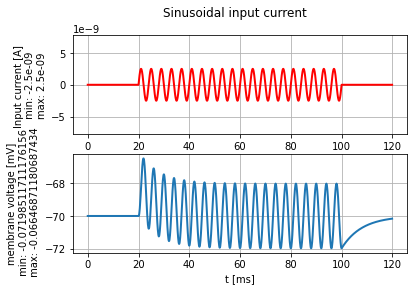

In [114]:
# note the higher resolution when discretizing the sine wave: we specify unit_time=0.1 * b2.ms
sinusoidal_current = input_factory.get_sinusoidal_current(200, 1000, unit_time=0.1 * b2.ms,
                                            amplitude= 2.5 * b2.namp, frequency=250*b2.Hz,
                                            direct_current=0. * b2.namp)

# run the LIF model. By setting the firing threshold to to a high value, we make sure to stay in the linear (non spiking) regime.
(state_monitor, spike_monitor) = LIF.simulate_LIF_neuron(input_current=sinusoidal_current, simulation_time = 120 * b2.ms, firing_threshold=0*b2.mV)

# plot the membrane voltage
plot_tools.plot_voltage_and_current_traces(state_monitor, sinusoidal_current, title="Sinusoidal input current")
print("nr of spikes: {}".format(spike_monitor.count[0]))

In [46]:
# We first find the number of peaks and use the most frequent peak height.
# In calculating the mode of the peaks, we do not include the beginning
# or end of the sin wave.
def find_amplitude_sin_wave(sin_wave):
    sr = 100.0
    ts = 1.0/sr
    t = np.arange(0,1,ts)
    
    freq = 20
    y = np.sin(2*np.pi*freq*t)
    
    temp = (np.max(y) - np.min(y))/2
    f = find_peaks(sin_wave)

    f_pos = find_peaks(sin_wave)
    f_pos_val = sin_wave[f_pos[0]]
    
    f_neg = find_peaks(-sin_wave)
    f_neg_val = sin_wave[f_neg[0]]
    
    f_pos_val = f_pos_val[:len(f_neg_val)]
    
    amp = f_pos_val - f_neg_val
    avg_amp = mode(np.round(amp, 5))
    amp = np.sin(2*np.pi*freq*t)

    return avg_amp[0][0]


In [47]:
input_frequency_list = np.linspace(10, 1000, 50)
oscillation_amp_list = list()

for freq in input_frequency_list:
    sinusoidal_current = input_factory.get_sinusoidal_current(200, 1000, unit_time=0.1 * b2.ms,
                                            amplitude= 2.5 * b2.namp, frequency=freq*b2.Hz,
                                            direct_current=0. * b2.namp)

    # run the LIF model. By setting the firing threshold to to a high value, we make sure to stay in the linear (non spiking) regime.
    (state_monitor, spike_monitor) = LIF.simulate_LIF_neuron(input_current=sinusoidal_current, simulation_time = 120 * b2.ms, firing_threshold=0*b2.mV)
    
    sinusoid_amp = find_amplitude_sin_wave(state_monitor.v[0])
    oscillation_amp_list.append(sinusoid_amp)
    

In [ ]:
plt.figure()
plt.plot(input_frequency_list, oscillation_amp_list)
plt.xlabel('Input frequency (Hz)')
plt.ylabel('Oscillation amplitude (mV)')
plt.show()

In [95]:

def calculate_phase_shift(current_val, voltage_val):
 # Calculate time shift.   
    time_shift = np.argmax(sp.signal.correlate(current_val, voltage_val))
# Formula for phase shift.   
    phase_shift = (1/360) * time_shift / 0.1
    phase_shift = math.floor(phase_shift * 10)
    #print(math.floor(test_shift * 10))
    return phase_shift
    

In [98]:
# test run on example
a = np.array([0, 1, 2, 3, 4, 3, 2, 1, 0, 1, 2, 3, 4, 3, 2, 1, 0, 0, 0, 0, 0])
b = np.array([0, 0, 0, 0, 0, 1, 2, 3, 4, 3, 2, 1, 0, 1, 2, 3, 4, 3, 2, 1, 0])

# expect a phase shift value of 4 (arbitrary units)
print('Phase shift: %.2f' % calculate_phase_shift(a, b))


-4
Phase shift: 4.00


In [96]:
input_frequency_list = np.linspace(10, 1000, 50)
phase_shift_list = list()

for freq in input_frequency_list:
    sinusoidal_current = input_factory.get_sinusoidal_current(200, 1000, unit_time=0.1 * b2.ms,
                                            amplitude= 2.5 * b2.namp, frequency=freq*b2.Hz,
                                            direct_current=0. * b2.namp)

    # run the LIF model. By setting the firing threshold to to a high value, we make sure to stay in the linear (non spiking) regime.
    (state_monitor, spike_monitor) = LIF.simulate_LIF_neuron(input_current=sinusoidal_current, simulation_time = 120 * b2.ms, firing_threshold=0*b2.mV)
    
    current_val = np.asarray(sinusoidal_current.values)
    current_val = np.squeeze(current_val)
    
    voltage_val = np.asarray(state_monitor.v[0])
    # voltage_val = voltage_val[200:1000] # only when current is ON
    #time = 0.1 * b2.ms
    phase_shift_no_units = calculate_phase_shift(current_val, voltage_val)
    phase_shift = phase_shift_no_units * 0.1 * b2.ms 
    phase_shift_list.append(phase_shift)

1891
818
1508
1441
942
1427
936
1421
1403
959
1403
954
1404
1393
965
1395
961
1396
1389
968
1391
964
1392
1386
970
1388
2024
1389
1385
1391
1386
2126
1388
1384
1389
1385
1983
1386
2106
1387
1384
2125
1397
1977
1386
1384
2130
1395
2048
1385


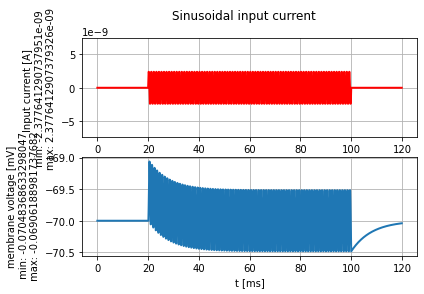

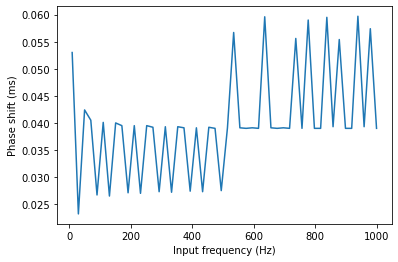

In [97]:
# plot the membrane voltage
plot_tools.plot_voltage_and_current_traces(state_monitor, sinusoidal_current, title="Sinusoidal input current")

plt.figure()
plt.plot(input_frequency_list, phase_shift_list)
plt.ylabel('Phase shift (ms)')
plt.xlabel('Input frequency (Hz)')
plt.show()

In [ ]:
input_frequency_list = np.linspace(10, 1000, 50)
oscillation_amp_list = list()

for freq in input_frequency_list:
    sinusoidal_current = input_factory.get_sinusoidal_current(200, 1000, unit_time=0.1 * b2.ms,
                                            amplitude= 2.5 * b2.namp, frequency=freq*b2.Hz,
                                            direct_current=0. * b2.namp)

    # run the LIF model. By setting the firing threshold to to a high value, we make sure to stay in the linear (non spiking) regime.
    (state_monitor, spike_monitor) = LIF.simulate_LIF_neuron(input_current=sinusoidal_current, simulation_time = 120 * b2.ms, firing_threshold=0*b2.mV)
    
    sinusoid_amp = find_amplitude_sin_wave(state_monitor.v[0])
    oscillation_amp_list.append(sinusoid_amp)

In [ ]:
# plot the membrane voltage
plot_tools.plot_voltage_and_current_traces(state_monitor, sinusoidal_current, title="Sinusoidal input current")
print("nr of spikes: {}".format(spike_monitor.count[0]))